## Molecular Solubility Prediction Through Graph Neural Networks


In [4]:
#C 
import torch
import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d, Dropout, Sequential, ReLU
from torch_geometric.nn import NNConv, GCNConv, global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
import warnings
warnings.filterwarnings("ignore")

# --- Device Selection ---
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Using CUDA GPU")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using APPLE MPS")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU")

# --- Configuration ---
NUM_GRAPHS_PER_BATCH = 64
LEARNING_RATE = 0.00025
EPOCHS = 100

# --- Load and Split Dataset ---
dataset = MoleculeNet(".", name="ESOL")

# Shuffle dataset
#torch.manual_seed(37837874)
torch.manual_seed(1011)
dataset = dataset.shuffle()

# Calculate split sizes
total_count = len(dataset)
train_count = int(0.8 * total_count)
val_count = int(0.1 * total_count)
test_count = total_count - train_count - val_count

# Perform the split
train_dataset = dataset[:train_count]
val_dataset = dataset[train_count:train_count + val_count]
test_dataset = dataset[train_count + val_count:]

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")
print(f"Using device: {DEVICE}")

# --- Create DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)




class MolecularGCN_EdgeNet(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, embedding_dim=64, dropout=0.05):
        super(MolecularGCN_EdgeNet, self).__init__()
        self.embedding_dim = embedding_dim
        self.node_encoder = Linear(num_node_features, embedding_dim)

        # --- Edge-conditioned NNConv layers ---
        edge_nn1 = Sequential(
            Linear(num_edge_features, embedding_dim // 2),
            ReLU(),
            Dropout(dropout),
            Linear(embedding_dim // 2, embedding_dim * embedding_dim)
        )
        self.edge_conv1 = NNConv(embedding_dim, embedding_dim, edge_nn1, aggr="mean")
        self.bn_edge1 = BatchNorm1d(embedding_dim)

        edge_nn2 = Sequential(
            Linear(num_edge_features, embedding_dim // 2),
            ReLU(),
            Dropout(dropout),
            Linear(embedding_dim // 2, embedding_dim * embedding_dim)
        )
        self.edge_conv2 = NNConv(embedding_dim, embedding_dim, edge_nn2, aggr="mean")
        self.bn_edge2 = BatchNorm1d(embedding_dim)

        # --- Standard GCN layers ---
        self.conv1 = GCNConv(embedding_dim, embedding_dim)
        self.bn_conv1 = BatchNorm1d(embedding_dim)
        self.conv2 = GCNConv(embedding_dim, embedding_dim)
        self.bn_conv2 = BatchNorm1d(embedding_dim)

        self.dropout = Dropout(dropout)

        # --- Final MLP ---
        pool_dim = embedding_dim * 3  # mean + max + sum pooling
        self.fc1 = Linear(pool_dim, embedding_dim * 3)
        self.fc_bn = BatchNorm1d(embedding_dim * 3)
        self.fc2 = Linear(embedding_dim * 3, embedding_dim)
        self.out = Linear(embedding_dim, 1)

    def forward(self, x, edge_index, batch_index, edge_attr):
        edge_attr = (edge_attr - edge_attr.mean(dim=0)) / (edge_attr.std(dim=0) + 1e-6)
        x = F.relu(self.node_encoder(x))

        # 2. Edge-Aware Message Passing
        x_res = x
        x = self.edge_conv1(x, edge_index, edge_attr)
        x = self.bn_edge1(x)
        x = F.relu(x)
        x= x + x_res
        x = self.dropout(x)


        x_res = x
        x = self.edge_conv2(x, edge_index, edge_attr)
        x = self.bn_edge2(x)
        x = F.relu(x)
        x = x + x_res

        # 3. Standard Graph Convolutions
        x_res = x
        x = self.conv1(x, edge_index)
        x = self.bn_conv1(x)
        x = F.relu(x)
        x = x+x_res
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn_conv2(x)
        x = F.relu(x)
     

        # 4. Multi-scale Global Pooling
        x_mean = global_mean_pool(x, batch_index)
        x_max = global_max_pool(x, batch_index)
        x_sum = global_add_pool(x, batch_index)
        x = torch.cat([x_mean, x_max, x_sum], dim=1)

        # 5. Prediction Head
        x = F.relu(self.fc_bn(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)

        out = self.out(x)
        return out, x



# --- Evaluation Function ---
def evaluate(model, loader):
    model.eval()
    total_loss = 0
    loss_fn = torch.nn.MSELoss()
    
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(DEVICE)
            pred, _ = model(batch.x.float(), batch.edge_index, batch.batch, batch.edge_attr.float())
            loss = loss_fn(pred, batch.y.view(-1, 1).float())
            total_loss += loss.item() * batch.num_graphs
    
    return total_loss / len(loader.dataset)


# --- Training Function ---
def run_training(model, train_loader, val_loader):
    model.to(DEVICE)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=2e-6)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.6,
        patience=12,
        min_lr=1e-5,
        )
    loss_fn = torch.nn.MSELoss()
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    print("Starting Training...")
    for epoch in range(EPOCHS):
        # --- Training ---
        model.train()
        epoch_loss = 0
        
        for batch in train_loader:
            batch = batch.to(DEVICE)
            optimizer.zero_grad()

            pred, _ = model(batch.x.float(), batch.edge_index, batch.batch, batch.edge_attr.float())
            loss = loss_fn(pred, batch.y.view(-1, 1).float())
            loss.backward()

            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # --- Validation ---
        val_loss = evaluate(model, val_loader)
        val_losses.append(val_loss)
        
        # Step scheduler based on validation loss
        scheduler.step(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')

        if epoch % 10 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch:4d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {current_lr:.6f}")

    return train_losses, val_losses


# --- Execution ---
# Get feature dimensions from dataset
num_node_features = dataset.num_node_features
num_edge_features = dataset.num_edge_features

print(f"Node features: {num_node_features}, Edge features: {num_edge_features}")

# Initialize model
model = MolecularGCN_EdgeNet(
    num_node_features=num_node_features,
    num_edge_features=num_edge_features
)

# Train
train_losses, val_losses = run_training(model, train_loader, val_loader)

# --- Final Evaluation on Test Set ---
model.load_state_dict(torch.load('best_model.pt'))
test_loss = evaluate(model, test_loader)
print(f"\n{'='*50}")
print(f"Final Test Loss (MSE): {test_loss:.4f}")
print(f"Final Test RMSE: {test_loss**0.5:.4f}")

Using APPLE MPS
Train: 902, Val: 112, Test: 114
Using device: mps
Node features: 9, Edge features: 3
Starting Training...
Epoch    0 | Train Loss: 12.7805 | Val Loss: 8.4734 | LR: 0.000250
Epoch   10 | Train Loss: 1.2729 | Val Loss: 1.0312 | LR: 0.000250
Epoch   20 | Train Loss: 0.9465 | Val Loss: 0.9428 | LR: 0.000250
Epoch   30 | Train Loss: 0.8020 | Val Loss: 0.6606 | LR: 0.000250
Epoch   40 | Train Loss: 0.6539 | Val Loss: 0.5403 | LR: 0.000250
Epoch   50 | Train Loss: 0.6266 | Val Loss: 0.5482 | LR: 0.000250
Epoch   60 | Train Loss: 0.5762 | Val Loss: 0.4612 | LR: 0.000250
Epoch   70 | Train Loss: 0.5385 | Val Loss: 0.4654 | LR: 0.000250
Epoch   80 | Train Loss: 0.5236 | Val Loss: 0.5347 | LR: 0.000250
Epoch   90 | Train Loss: 0.5308 | Val Loss: 0.4452 | LR: 0.000150

Final Test Loss (MSE): 0.4724
Final Test RMSE: 0.6873


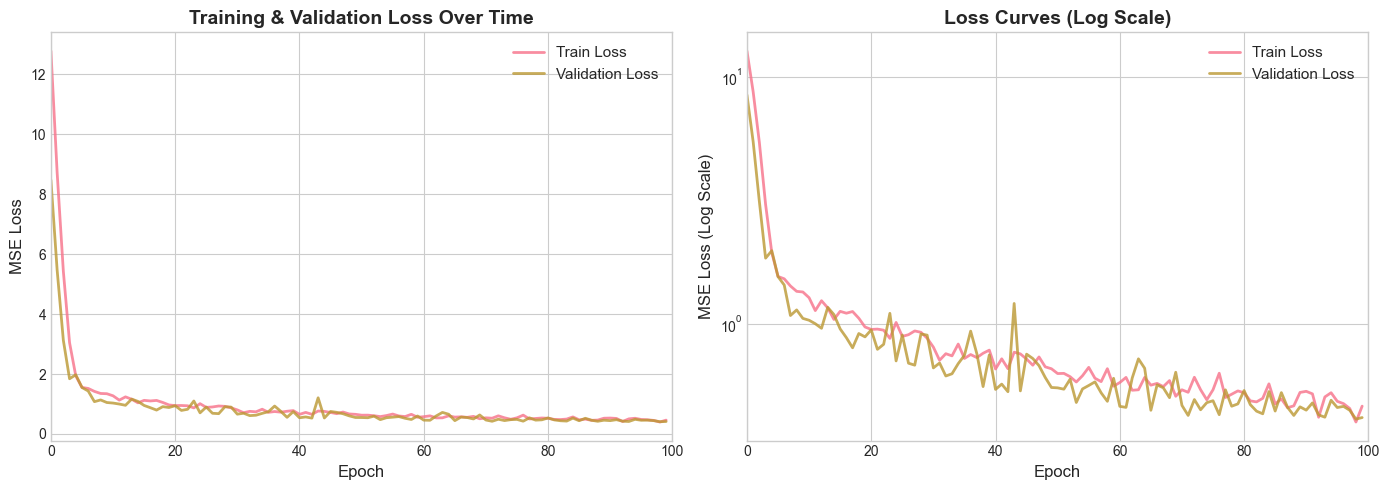

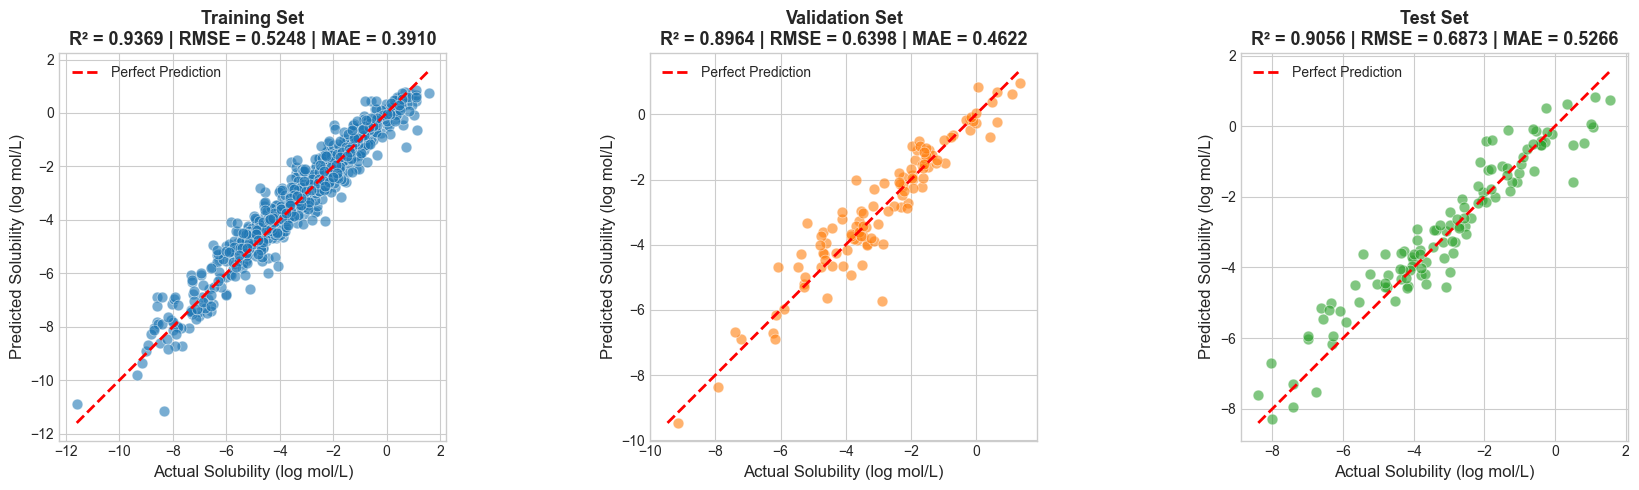

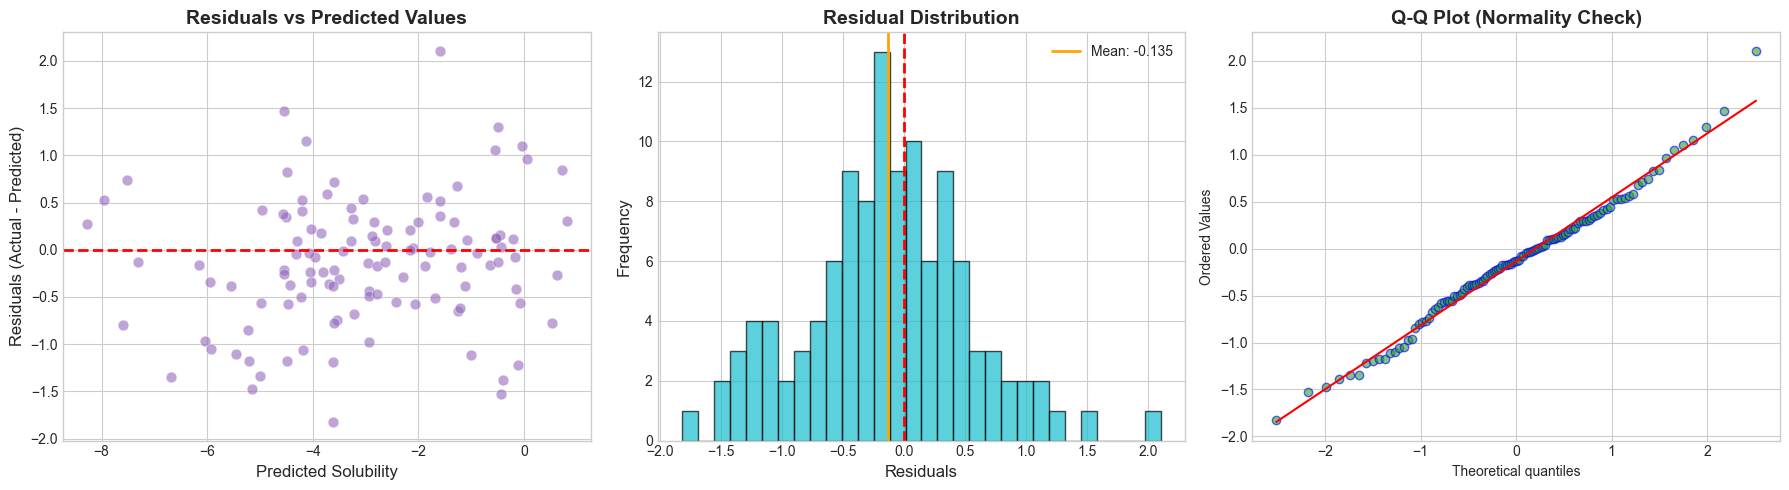


RESIDUAL STATISTICS (Test Set)
Mean Residual: -0.1354
Std Residual:  0.6739
Min Residual:  -1.8235
Max Residual:  2.1060


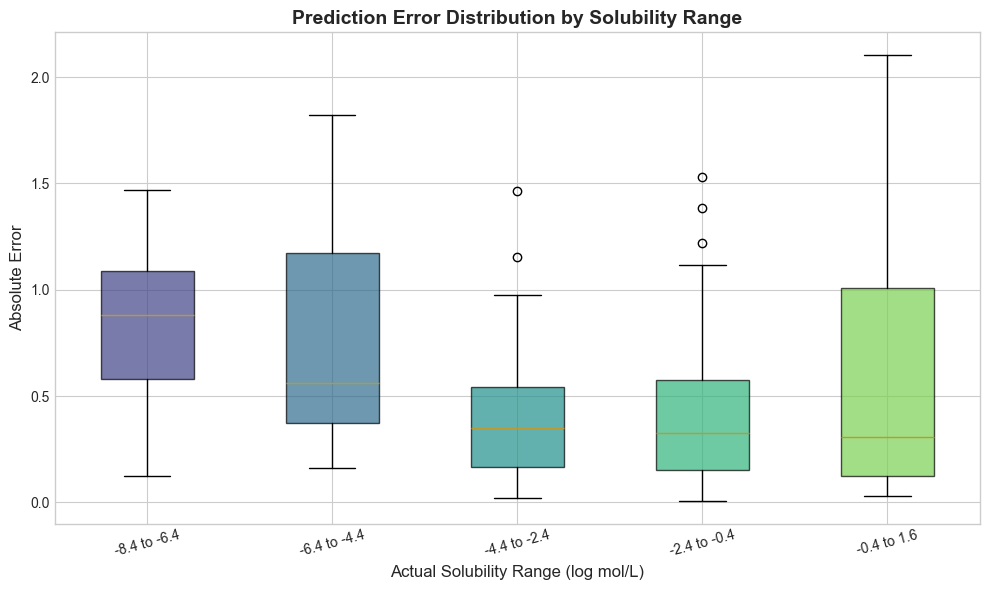


Computing t-SNE embeddings...


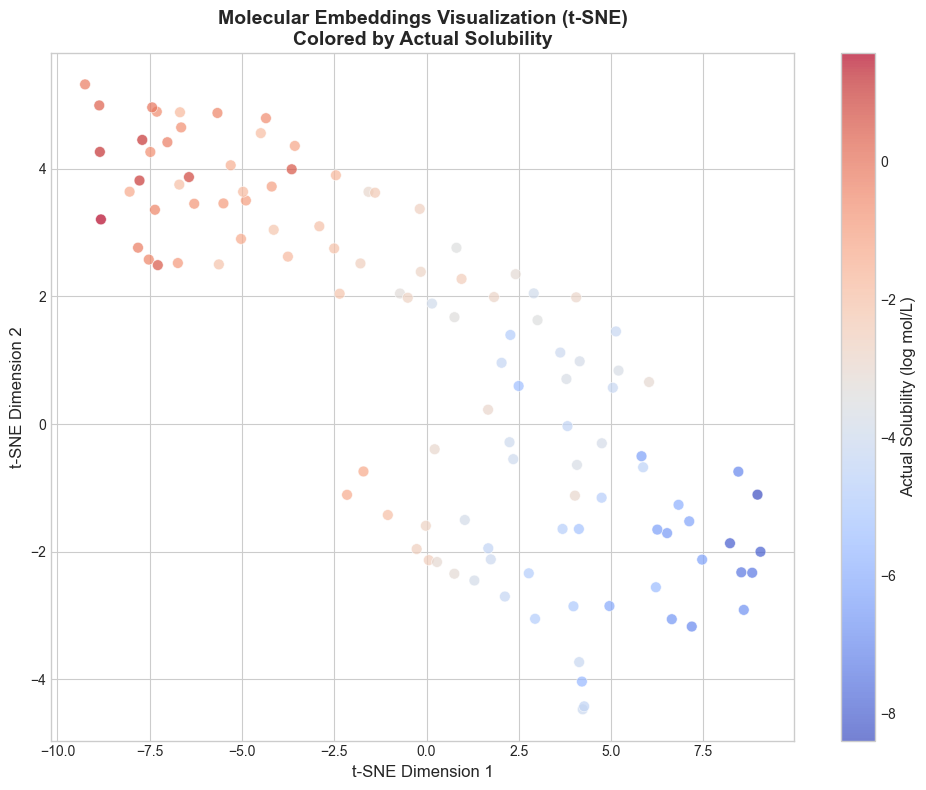

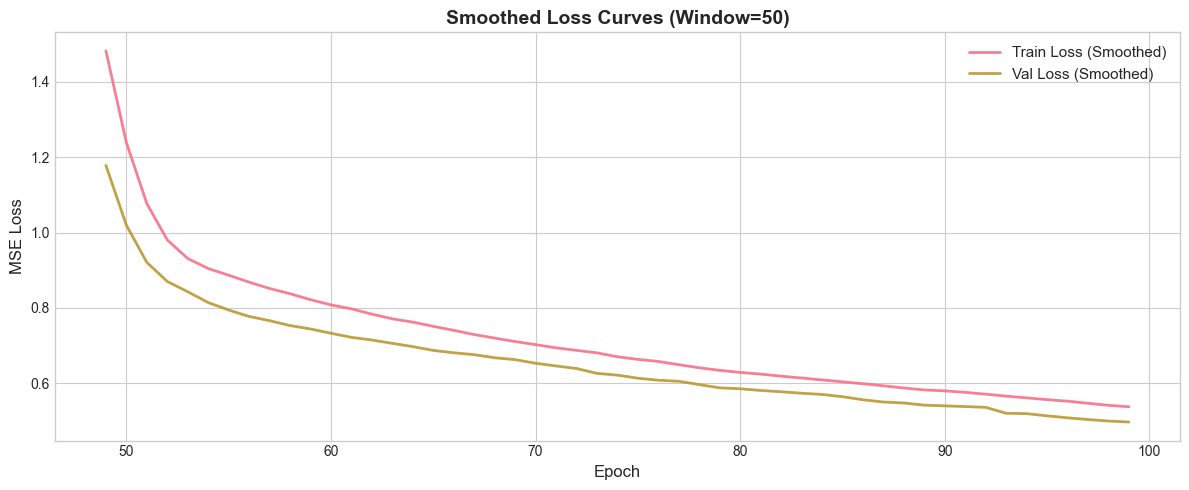


                    FINAL MODEL PERFORMANCE SUMMARY

Dataset                MSE       RMSE        MAE         R²
-------------------------------------------------------
Train               0.2755     0.5248     0.3910     0.9369
Validation          0.4094     0.6398     0.4622     0.8964
Test                0.4724     0.6873     0.5266     0.9056


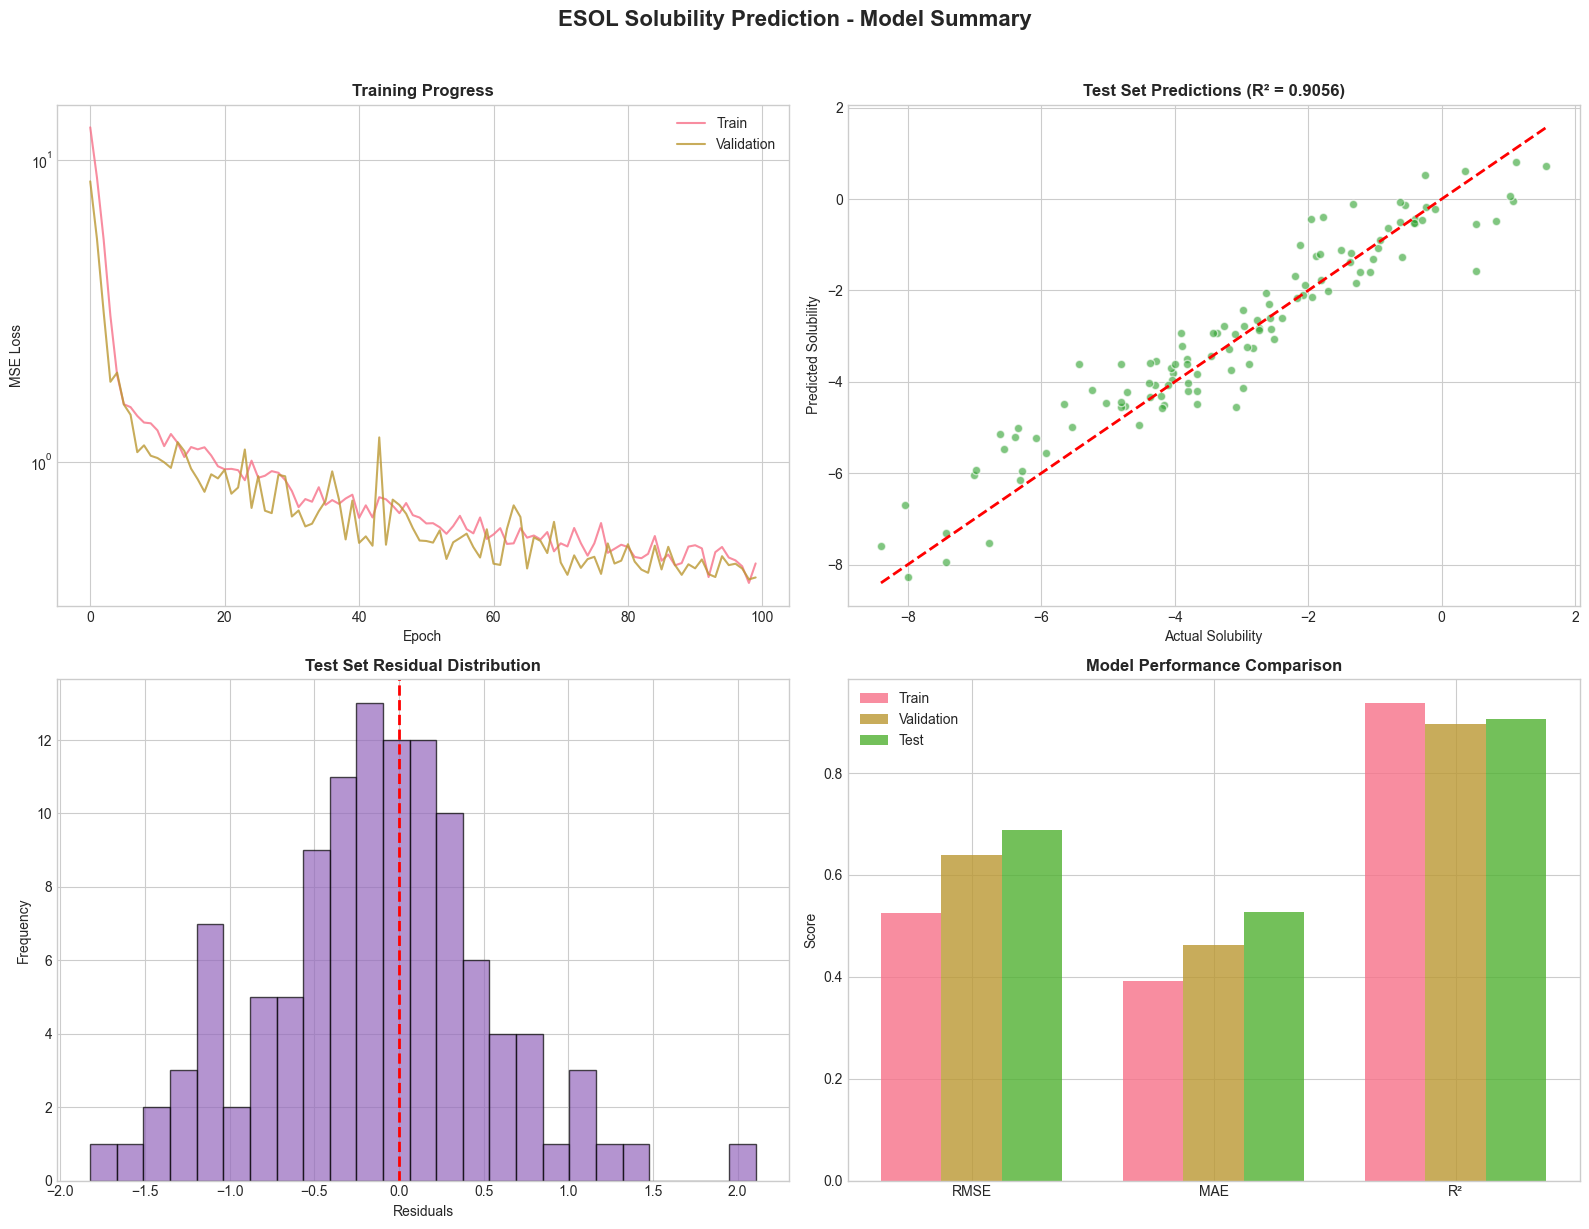


✅ All visualizations saved!
   - loss_curves.png
   - predictions_vs_actual.png
   - residual_analysis.png
   - error_by_bins.png
   - tsne_embeddings.png
   - smoothed_losses.png
   - model_summary.png


In [6]:
# ============================================================
# VISUALIZATION SECTION
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# --- 1. Training and Validation Loss Curves ---
def plot_loss_curves(train_losses, val_losses):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Full loss curves
    ax1 = axes[0]
    epochs = range(len(train_losses))
    ax1.plot(epochs, train_losses, label='Train Loss', alpha=0.8, linewidth=2)
    ax1.plot(epochs, val_losses, label='Validation Loss', alpha=0.8, linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('MSE Loss', fontsize=12)
    ax1.set_title('Training & Validation Loss Over Time', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.set_xlim(0, len(train_losses))
    
    # Plot 2: Log scale loss curves
    ax2 = axes[1]
    ax2.plot(epochs, train_losses, label='Train Loss', alpha=0.8, linewidth=2)
    ax2.plot(epochs, val_losses, label='Validation Loss', alpha=0.8, linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('MSE Loss (Log Scale)', fontsize=12)
    ax2.set_title('Loss Curves (Log Scale)', fontsize=14, fontweight='bold')
    ax2.set_yscale('log')
    ax2.legend(fontsize=11)
    ax2.set_xlim(0, len(train_losses))
    
    plt.tight_layout()
    plt.savefig('loss_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_loss_curves(train_losses, val_losses)


# --- 2. Get Predictions for All Sets ---
def get_predictions(model, loader):
    model.eval()
    predictions = []
    actuals = []
    embeddings = []
    
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(DEVICE)
            pred, emb = model(batch.x.float(), batch.edge_index, batch.batch, batch.edge_attr.float())
            predictions.extend(pred.cpu().numpy().flatten())
            actuals.extend(batch.y.cpu().numpy().flatten())
            embeddings.append(emb.cpu().numpy())
    
    embeddings = np.vstack(embeddings)
    return np.array(predictions), np.array(actuals), embeddings

# Load best model
model.load_state_dict(torch.load('best_model.pt'))
model.to(DEVICE)

# Get predictions for all datasets
train_preds, train_actuals, train_embeddings = get_predictions(model, train_loader)
val_preds, val_actuals, val_embeddings = get_predictions(model, val_loader)
test_preds, test_actuals, test_embeddings = get_predictions(model, test_loader)


# --- 3. Prediction vs Actual Scatter Plots ---
def plot_predictions_vs_actual(train_preds, train_actuals, val_preds, val_actuals, test_preds, test_actuals):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    datasets = [
        (train_preds, train_actuals, 'Training Set', 'tab:blue'),
        (val_preds, val_actuals, 'Validation Set', 'tab:orange'),
        (test_preds, test_actuals, 'Test Set', 'tab:green')
    ]
    
    for ax, (preds, actuals, title, color) in zip(axes, datasets):
        # Calculate metrics
        r2 = r2_score(actuals, preds)
        rmse = np.sqrt(np.mean((preds - actuals) ** 2))
        mae = mean_absolute_error(actuals, preds)
        
        # Scatter plot
        ax.scatter(actuals, preds, alpha=0.6, c=color, edgecolors='white', linewidth=0.5, s=60)
        
        # Perfect prediction line
        min_val = min(actuals.min(), preds.min())
        max_val = max(actuals.max(), preds.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
        
        # Labels and title
        ax.set_xlabel('Actual Solubility (log mol/L)', fontsize=12)
        ax.set_ylabel('Predicted Solubility (log mol/L)', fontsize=12)
        ax.set_title(f'{title}\nR² = {r2:.4f} | RMSE = {rmse:.4f} | MAE = {mae:.4f}', 
                     fontsize=13, fontweight='bold')
        ax.legend(loc='upper left', fontsize=10)
        
        # Equal aspect ratio
        ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.savefig('predictions_vs_actual.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_predictions_vs_actual(train_preds, train_actuals, val_preds, val_actuals, test_preds, test_actuals)


# --- 4. Residual Analysis ---
def plot_residual_analysis(test_preds, test_actuals):
    residuals = test_actuals - test_preds
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Residuals vs Predicted
    ax1 = axes[0]
    ax1.scatter(test_preds, residuals, alpha=0.6, c='tab:purple', edgecolors='white', linewidth=0.5, s=60)
    ax1.axhline(y=0, color='red', linestyle='--', linewidth=2)
    ax1.set_xlabel('Predicted Solubility', fontsize=12)
    ax1.set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
    ax1.set_title('Residuals vs Predicted Values', fontsize=14, fontweight='bold')
    
    # Plot 2: Residual Distribution
    ax2 = axes[1]
    ax2.hist(residuals, bins=30, color='tab:cyan', edgecolor='black', alpha=0.7)
    ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax2.axvline(x=residuals.mean(), color='orange', linestyle='-', linewidth=2, label=f'Mean: {residuals.mean():.3f}')
    ax2.set_xlabel('Residuals', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Residual Distribution', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    
    # Plot 3: Q-Q Plot
    ax3 = axes[2]
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plot (Normality Check)', fontsize=14, fontweight='bold')
    ax3.get_lines()[0].set_markerfacecolor('tab:green')
    ax3.get_lines()[0].set_alpha(0.6)
    
    plt.tight_layout()
    plt.savefig('residual_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print residual statistics
    print("\n" + "="*50)
    print("RESIDUAL STATISTICS (Test Set)")
    print("="*50)
    print(f"Mean Residual: {residuals.mean():.4f}")
    print(f"Std Residual:  {residuals.std():.4f}")
    print(f"Min Residual:  {residuals.min():.4f}")
    print(f"Max Residual:  {residuals.max():.4f}")

plot_residual_analysis(test_preds, test_actuals)


# --- 5. Error Distribution by Actual Value Bins ---
def plot_error_by_bins(test_preds, test_actuals):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bins based on actual values
    bins = np.linspace(test_actuals.min(), test_actuals.max(), 6)
    bin_labels = [f'{bins[i]:.1f} to {bins[i+1]:.1f}' for i in range(len(bins)-1)]
    
    # Calculate absolute errors
    abs_errors = np.abs(test_actuals - test_preds)
    
    # Assign each point to a bin
    bin_indices = np.digitize(test_actuals, bins) - 1
    bin_indices = np.clip(bin_indices, 0, len(bin_labels) - 1)
    
    # Group errors by bin
    binned_errors = [abs_errors[bin_indices == i] for i in range(len(bin_labels))]
    
    # Box plot
    bp = ax.boxplot(binned_errors, labels=bin_labels, patch_artist=True)
    
    # Color the boxes
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(bin_labels)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_xlabel('Actual Solubility Range (log mol/L)', fontsize=12)
    ax.set_ylabel('Absolute Error', fontsize=12)
    ax.set_title('Prediction Error Distribution by Solubility Range', fontsize=14, fontweight='bold')
    plt.xticks(rotation=15)
    
    plt.tight_layout()
    plt.savefig('error_by_bins.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_error_by_bins(test_preds, test_actuals)


# --- 6. Molecular Embeddings Visualization (t-SNE) ---
def plot_embeddings_tsne(test_embeddings, test_actuals):
    from sklearn.manifold import TSNE
    
    print("\nComputing t-SNE embeddings...")
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(test_embeddings)-1))
    embeddings_2d = tsne.fit_transform(test_embeddings)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Scatter plot colored by actual solubility
    scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                         c=test_actuals, cmap='coolwarm', 
                         alpha=0.7, s=60, edgecolors='white', linewidth=0.5)
    
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Actual Solubility (log mol/L)', fontsize=12)
    
    ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
    ax.set_title('Molecular Embeddings Visualization (t-SNE)\nColored by Actual Solubility', 
                 fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('tsne_embeddings.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_embeddings_tsne(test_embeddings, test_actuals)




# --- 7. Learning Rate Schedule Visualization ---
def plot_lr_analysis(train_losses, val_losses):
    fig, ax = plt.subplots(figsize=(12, 5))
    
    # Calculate smoothed losses using moving average
    window = 50
    train_smooth = np.convolve(train_losses, np.ones(window)/window, mode='valid')
    val_smooth = np.convolve(val_losses, np.ones(window)/window, mode='valid')
    
    epochs_smooth = range(window-1, len(train_losses))
    
    ax.plot(epochs_smooth, train_smooth, label='Train Loss (Smoothed)', linewidth=2, alpha=0.9)
    ax.plot(epochs_smooth, val_smooth, label='Val Loss (Smoothed)', linewidth=2, alpha=0.9)
    
    # Mark potential LR reduction points (where loss suddenly drops or plateaus)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('MSE Loss', fontsize=12)
    ax.set_title(f'Smoothed Loss Curves (Window={window})', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    
    plt.tight_layout()
    plt.savefig('smoothed_losses.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_lr_analysis(train_losses, val_losses)


# --- 8. Comprehensive Metrics Summary ---
def print_metrics_summary(train_preds, train_actuals, val_preds, val_actuals, test_preds, test_actuals):
    
    def compute_metrics(preds, actuals):
        mse = np.mean((preds - actuals) ** 2)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(actuals, preds)
        r2 = r2_score(actuals, preds)
        return mse, rmse, mae, r2
    
    print("\n" + "="*70)
    print(" " * 20 + "FINAL MODEL PERFORMANCE SUMMARY")
    print("="*70)
    
    print(f"\n{'Dataset':<15} {'MSE':>10} {'RMSE':>10} {'MAE':>10} {'R²':>10}")
    print("-"*55)
    
    for name, preds, actuals in [('Train', train_preds, train_actuals),
                                   ('Validation', val_preds, val_actuals),
                                   ('Test', test_preds, test_actuals)]:
        mse, rmse, mae, r2 = compute_metrics(preds, actuals)
        print(f"{name:<15} {mse:>10.4f} {rmse:>10.4f} {mae:>10.4f} {r2:>10.4f}")
    
    print("="*70)

print_metrics_summary(train_preds, train_actuals, val_preds, val_actuals, test_preds, test_actuals)


# --- 9. Combined Summary Figure ---
def create_summary_figure(train_losses, val_losses, train_preds, train_actuals, 
                          val_preds, val_actuals, test_preds, test_actuals):
    
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Loss curves (top left)
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.plot(train_losses, label='Train', alpha=0.8)
    ax1.plot(val_losses, label='Validation', alpha=0.8)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss')
    ax1.set_title('Training Progress', fontweight='bold')
    ax1.legend()
    ax1.set_yscale('log')
    
    # 2. Test predictions (top right)
    ax2 = fig.add_subplot(2, 2, 2)
    r2 = r2_score(test_actuals, test_preds)
    ax2.scatter(test_actuals, test_preds, alpha=0.6, c='tab:green', edgecolors='white')
    min_val, max_val = min(test_actuals.min(), test_preds.min()), max(test_actuals.max(), test_preds.max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    ax2.set_xlabel('Actual Solubility')
    ax2.set_ylabel('Predicted Solubility')
    ax2.set_title(f'Test Set Predictions (R² = {r2:.4f})', fontweight='bold')
    
    # 3. Residual histogram (bottom left)
    ax3 = fig.add_subplot(2, 2, 3)
    residuals = test_actuals - test_preds
    ax3.hist(residuals, bins=25, color='tab:purple', edgecolor='black', alpha=0.7)
    ax3.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax3.set_xlabel('Residuals')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Test Set Residual Distribution', fontweight='bold')
    
    # 4. Metrics comparison bar chart (bottom right)
    ax4 = fig.add_subplot(2, 2, 4)
    
    metrics = ['RMSE', 'MAE', 'R²']
    train_metrics = [np.sqrt(np.mean((train_preds - train_actuals)**2)),
                     mean_absolute_error(train_actuals, train_preds),
                     r2_score(train_actuals, train_preds)]
    val_metrics = [np.sqrt(np.mean((val_preds - val_actuals)**2)),
                   mean_absolute_error(val_actuals, val_preds),
                   r2_score(val_actuals, val_preds)]
    test_metrics = [np.sqrt(np.mean((test_preds - test_actuals)**2)),
                    mean_absolute_error(test_actuals, test_preds),
                    r2_score(test_actuals, test_preds)]
    
    x = np.arange(len(metrics))
    width = 0.25
    
    ax4.bar(x - width, train_metrics, width, label='Train', alpha=0.8)
    ax4.bar(x, val_metrics, width, label='Validation', alpha=0.8)
    ax4.bar(x + width, test_metrics, width, label='Test', alpha=0.8)
    
    ax4.set_ylabel('Score')
    ax4.set_title('Model Performance Comparison', fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics)
    ax4.legend()
    
    plt.suptitle('ESOL Solubility Prediction - Model Summary', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('model_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

create_summary_figure(train_losses, val_losses, train_preds, train_actuals,
                      val_preds, val_actuals, test_preds, test_actuals)

print("\n✅ All visualizations saved!")
print("   - loss_curves.png")
print("   - predictions_vs_actual.png")
print("   - residual_analysis.png")
print("   - error_by_bins.png")
print("   - tsne_embeddings.png")
print("   - smoothed_losses.png")
print("   - model_summary.png")